In [25]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
import csv
data = []
with open("cleaned/NY.csv", "r", encoding="utf-8") as f:
    csv_reader = csv.reader(f, delimiter=',')
    headers = next(csv_reader)
    for i in csv_reader:
        data.append(int(i[5]))

train  = data[:-300]
test = data[-300:]

li_x = []
li_y = []
seq = 2

# 因为数据集较少，序列长度太长会影响结果
for i in range(len(data[:-300]) - seq):
    # 输入就是[x,x+1]天的数据，输出时x+2天的数据
    li_x.append(train[i: i+seq])
    li_y.append(train[i+seq])

t_x = []
t_y = []
# 因为数据集较少，序列长度太长会影响结果
for i in range(len(data[-300:]) - seq):
    # 输入就是[x,x+1]天的数据，输出时x+2天的数据*
    t_x.append(test[i: i+seq])
    t_y.append(test[i+seq])

# print(li_x)
# print(li_y)

# 分训练和测试集
train_x = (torch.tensor(li_x).float() / 1000.).reshape(-1, seq, 1).to(device)
train_y = (torch.tensor(li_y).float() / 1000.).reshape(-1, 1).to(device)

print(train_x.shape)

test_x = (torch.tensor(t_x).float() / 1000.).reshape(-1, seq, 1).to(device)
test_y = (torch.tensor(t_y).float() / 1000.).reshape(-1, 1).to(device)

torch.Size([439, 2, 1])


In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        # 输入格式是1，输出隐藏层大小是32
        # 对于小数据集num_layers不要设置大，否则会因为模型变复杂而导致效果会变差
        # num_layers顾名思义就是有几个lstm层，假如设置成2，就相当于连续经过两个lstm层
        # 原来的输入格式是：(seq, batch, shape)
        # 设置batch_first=True以后，输入格式就可以改为：(batch, seq, shape)，更符合平常使用的习惯
        self.linear = nn.Linear(32*seq, 1)

    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x.reshape(-1, 32*seq)
        x = self.linear(x)
        return x

In [29]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003) #Learning Rate
loss_fun = nn.MSELoss()

In [30]:
model.train()
list_l = []
list_tl = []
for epoch in range(1200):
    output = model(train_x)
    loss = loss_fun(output, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    list_l.append(loss)
    if epoch % 20 == 0 and epoch > 0:
        test_loss = loss_fun(model(test_x), test_y)
        list_tl.append(test_loss)
        print("epoch:{}, loss:{}, test_loss: {}".format(epoch, loss, test_loss))

epoch:20, loss:5.847935676574707, test_loss: 61.218017578125
epoch:40, loss:1.6987186670303345, test_loss: 42.43565368652344
epoch:60, loss:0.8744928240776062, test_loss: 37.111629486083984
epoch:80, loss:0.6756331920623779, test_loss: 34.330650329589844
epoch:100, loss:0.5558894276618958, test_loss: 32.282657623291016
epoch:120, loss:0.4780732989311218, test_loss: 30.64041519165039
epoch:140, loss:0.42448511719703674, test_loss: 29.33324432373047
epoch:160, loss:0.3928593397140503, test_loss: 28.327573776245117
epoch:180, loss:0.37725427746772766, test_loss: 27.59881019592285
epoch:200, loss:0.37086284160614014, test_loss: 27.105669021606445
epoch:220, loss:0.36808037757873535, test_loss: 26.77191162109375
epoch:240, loss:0.3667321801185608, test_loss: 26.540904998779297
epoch:260, loss:0.3659280836582184, test_loss: 26.369182586669922
epoch:280, loss:0.3653144836425781, test_loss: 26.236480712890625
epoch:300, loss:0.36478614807128906, test_loss: 26.127857208251953
epoch:320, loss:0.

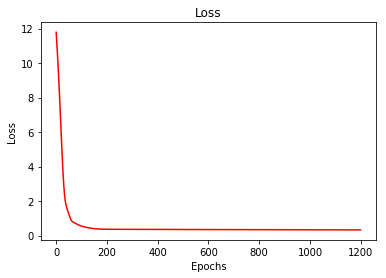

In [31]:
num_list = []
for i in range(len(list_l)):
    num_list.append(list_l[i].item())
x = np.array([i for i in range(len(list_l))])
#print(num_list)
plt.plot(x, num_list, color='r')
#plt.plot(x, num_list_, color='k')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('plot/NY_Loss.jpg')
plt.show()

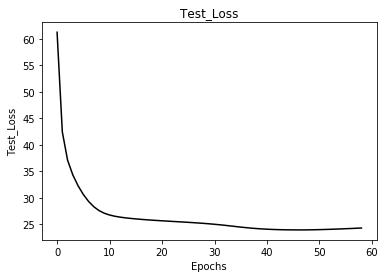

In [32]:
num_list_ = []
for i in range(len(list_tl)):
    num_list_.append(list_tl[i].item())
x = np.array([i for i in range(len(num_list_))])
#plt.plot(x, num_list, color='r')
plt.plot(x, num_list_, color='k')
plt.title('Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Test_Loss')
plt.savefig('plot/NY_Test_Loss.jpg')
plt.show()

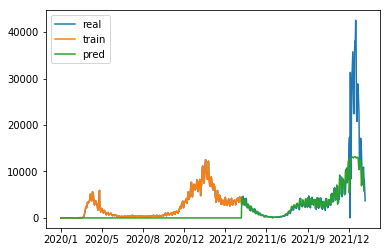

In [33]:
model.eval()
# result = li_x[0][:seq-1] + list((model(train_x).data.reshape(-1))*1000) + list((model(test_x).data.reshape(-1))*1000)
result = [0] + list((model(train_x).data.reshape(-1))*00) + list((model(test_x).data.reshape(-1))*1000)
#展示结果
plt.plot(data,label="real")
# 原来的走势

plt.plot(train,label="train")

plt.plot(result,label="pred")
plt.xticks(
    [0,100,200,300,400,500,600,700],
    ['2020/1','2020/5', '2020/8', '2020/12', '2021/2', '20211/6', '2021/9', '2021/12']
)
# 模型预测的走势
plt.legend(loc='best')
plt.savefig('plot/NY_Epoch1200.jpg')

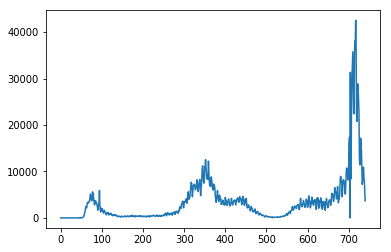

In [34]:
plt.plot(data)

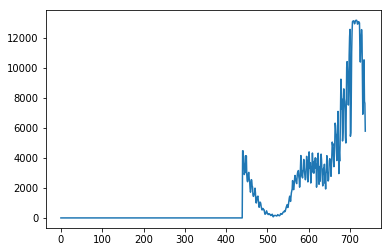

In [35]:
plt.plot(result)

In [36]:
# unpredictive
# 